In [10]:
import pandas as pd
import datetime as dt
import numpy as np
import investpy

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.models import load_model

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# Load data
df = pd.read_csv('xrp.csv')
print(df)

           Date     Open     High      Low    Close      Volume Currency
0    2020-06-01  0.20254  0.21184  0.20132  0.21090  1662996864      USD
1    2020-06-02  0.21090  0.21452  0.19826  0.20317  2046863744      USD
2    2020-06-03  0.20316  0.20475  0.20104  0.20411  1226735360      USD
3    2020-06-04  0.20411  0.20713  0.20121  0.20438  1357705728      USD
4    2020-06-05  0.20438  0.20567  0.20174  0.20282  1165720704      USD
..          ...      ...      ...      ...      ...         ...      ...
726  2022-05-28  0.38155  0.38868  0.38068  0.38637   333918176      USD
727  2022-05-29  0.38631  0.39004  0.37945  0.38910   279300928      USD
728  2022-05-30  0.38910  0.41955  0.38699  0.41859   552421952      USD
729  2022-05-31  0.41861  0.43342  0.40694  0.42156   634001152      USD
730  2022-06-01  0.42162  0.42625  0.38985  0.39802   671546560      USD

[731 rows x 7 columns]


In [3]:
# Process data
df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df['Close'].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df['Close'].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df['Close'].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df['Close'].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df['Close'].rolling(window=ma_3).std()
df.dropna(inplace=True)

df.to_csv("xrp_processed_8_2.csv")
df

,Date,Open,High,Low,Close,Volume,Currency,H-L,O-C,SMA_7,SMA_14,SMA_21,SD_7,SD_21
20,2020-06-21,0.18793,0.18840,0.18577,0.18606,623938624,USD,0.00263,0.00187,0.189860,0.192946,0.196841,0.002852,0.007476
21,2020-06-22,0.18606,0.19018,0.18584,0.18941,1066312000,USD,0.00434,-0.00335,0.189431,0.191899,0.195818,0.002621,0.006904
22,2020-06-23,0.18942,0.19042,0.18839,0.18886,793852224,USD,0.00203,0.00056,0.188927,0.191008,0.195137,0.002273,0.006848
23,2020-06-24,0.18886,0.19010,0.18179,0.18351,1010395648,USD,0.00831,0.00535,0.187546,0.189637,0.194156,0.002195,0.006973
24,2020-06-25,0.18352,0.18406,0.17897,0.18155,912398528,USD,0.00509,0.00197,0.186370,0.189149,0.193069,0.002892,0.007078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2022-05-28,0.38155,0.38868,0.38068,0.38637,333918176,USD,0.00800,-0.00482,0.400311,0.411512,0.427511,0.014112,0.044784
727,2022-05-29,0.38631,0.39004,0.37945,0.38910,279300928,USD,0.01059,-0.00279,0.395640,0.407309,0.419078,0.010848,0.032297
728,2022-05-30,0.38910,0.41955,0.38699,0.41859,552421952,USD,0.03256,-0.02949,0.397569,0.406996,0.415789,0.013647,0.028223
729,2022-05-31,0.41861,0.43342,0.40694,0.42156,634001152,USD,0.02648,-0.00295,0.399423,0.405830,0.411425,0.016061,0.017426


In [4]:
pre_day = 30
scala_x = MinMaxScaler(feature_range=(0,1))
scala_y = MinMaxScaler(feature_range=(0,1))
cols_x = ['H-L', 'O-C', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = ['Close']
scaled_data_x = scala_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x)))
scaled_data_y = scala_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

x_total = []
y_total = []

for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])

test_size = (int)(len(scaled_data_y) * 0.2)
print(test_size)

x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])



print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

142
(539, 30, 7) (539, 1) (142, 30, 7) (142, 1)


In [5]:
# Build model
model = Sequential()

model.add(LSTM(units=60, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=len(cols_y)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=120, steps_per_epoch=40, use_multiprocessing=True)
model.save("xrp_lstm_8_2.h5")

Epoch 1/120
40/40 [==============================] - 19s 99ms/step - loss: 0.0335
Epoch 2/120
40/40 [==============================] - 4s 96ms/step - loss: 0.0192
Epoch 3/120
40/40 [==============================] - 4s 102ms/step - loss: 0.0162
Epoch 4/120
40/40 [==============================] - 4s 97ms/step - loss: 0.0133
Epoch 5/120
40/40 [==============================] - 4s 94ms/step - loss: 0.0131
Epoch 6/120
40/40 [==============================] - 4s 97ms/step - loss: 0.0111
Epoch 7/120
40/40 [==============================] - 4s 97ms/step - loss: 0.0106
Epoch 8/120
40/40 [==============================] - 4s 107ms/step - loss: 0.0103
Epoch 9/120
40/40 [==============================] - 4s 101ms/step - loss: 0.0101
Epoch 10/120
40/40 [==============================] - 5s 122ms/step - loss: 0.0083
Epoch 11/120
40/40 [==============================] - 4s 104ms/step - loss: 0.0082
Epoch 12/120
40/40 [==============================] - 7s 168ms/step - loss: 0.0066
Epoch 13/120
40/40

In [6]:
# Testing
predict_price = model.predict(x_test)
predict_price = scala_y.inverse_transform(predict_price)

5/5 [==============================] - 3s 30ms/step


(142, 1)


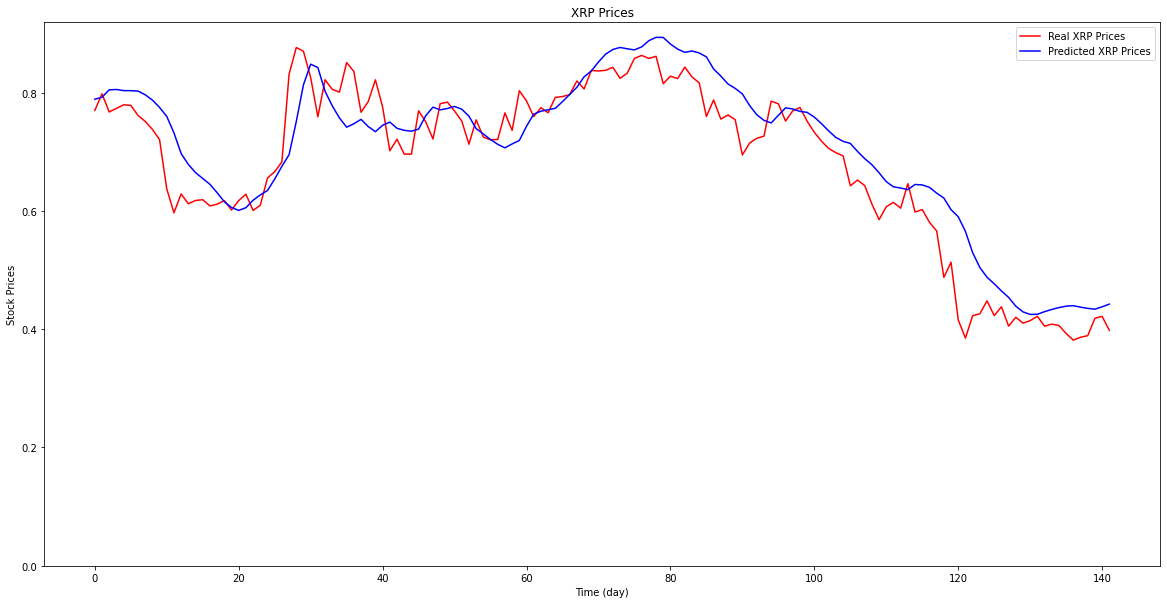

In [7]:
# Ploting the stat
real_price = df[len(df)-test_size:]['Close'].values.reshape(-1,1)
real_price = np.array(real_price)
print(real_price.shape)
real_price = real_price.reshape(real_price.shape[0], 1)

plt.figure(figsize=(20,10))
plt.plot(real_price, color="red", label="Real XRP Prices")
plt.plot(predict_price, color="blue", label="Predicted XRP Prices")
plt.title("XRP Prices")
plt.xlabel("Time (day)")
plt.ylabel("Stock Prices")
plt.ylim(bottom=0)
plt.legend()
plt.show()

In [8]:
# Make Prediction
x_predict = df[len(df)-pre_day:][cols_x].values.reshape(-1, len(cols_x))
x_predict = scala_x.transform(x_predict)
x_predict = np.array(x_predict)
x_predict = x_predict.reshape(1, x_predict.shape[0], len(cols_x))

prediction = model.predict(x_predict)
prediction = scala_y.inverse_transform(prediction)
print(prediction)

1/1 [==============================] - 0s 37ms/step
[[0.43982124]]


In [11]:
mae = mean_absolute_error(real_price, predict_price)
mape = mean_absolute_percentage_error(real_price, predict_price)
mse = mean_squared_error(real_price, predict_price)
rmse = np.sqrt(mse)
r2 = r2_score(real_price, predict_price)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 0.04
MAPE: 6.65%
MSE: 0.00
RMSE: 0.05
R2: 0.86
